# Toxic Words Text Classification Challenge

## Mount Drive and download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
PATH = '/content/drive/My Drive'
import os
os.chdir(PATH)

In [3]:
%tensorflow_version 2.x

In [4]:
os.makedirs('toxic_words', exist_ok=True)
os.chdir('toxic_words')

In [ ]:
!wget -qq https://www.dropbox.com/s/fz2d61pwgigtra7/toxic_words.zip
!unzip -qq toxic_words.zip

!rm toxic_words.zip

# !ls

## Import libraries and dataset

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import pandas as pd
import numpy as np

import tensorflow as tf

In [6]:
train_df = pd.read_csv("./train.csv").fillna("blank")
# test_df = pd.read_csv("./test.csv").fillna("blank")

In [7]:
train_df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [8]:
train_df.shape

(159571, 8)

In [9]:
X = train_df["comment_text"].values
y = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [10]:
y[0]

array([0, 0, 0, 0, 0, 0])

In [11]:
n = len(y[0])
n

6

## Visualize data

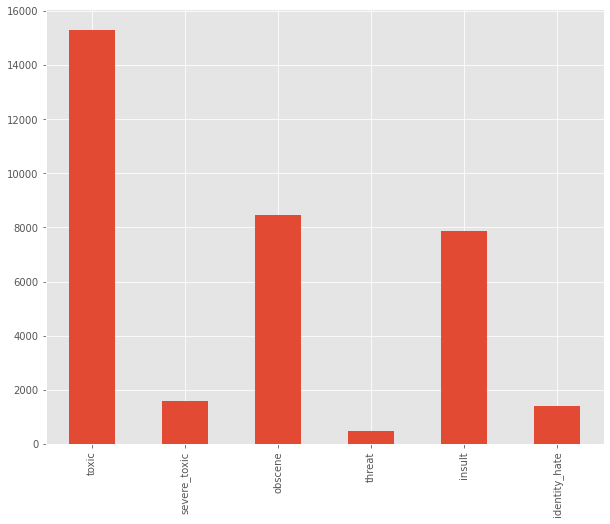

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=0).plot.bar()

## Preprocess text data

### Data cleaning

In [12]:
import re
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [13]:
X[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
preprocess_text(X[0])

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren vandalisms just closure on some GAs after voted at New York Dolls FAC And please don remove the template from the talk page since m retired now '

In [13]:
X_clean = [preprocess_text(i) for i in X]

### Split into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.20, random_state=42)

### Tokenize text and add padding

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Train Model

In [16]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *

### LSTM

In [19]:
inputs = Input(shape=(maxlen,))
x = Embedding(vocab_size, 100, trainable=False)(inputs)
x = LSTM(128)(x)
outputs = Dense(n, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14824300  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 15s 19ms/step - loss: 0.1467 - acc: 0.9756 - val_loss: 0.1427 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 14s 18ms/step - loss: 0.1409 - acc: 0.9941 - val_loss: 0.1423 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 15s 18ms/step - loss: 0.1409 - acc: 0.9941 - val_loss: 0.1425 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 15s 18ms/step - loss: 0.1408 - acc: 0.9941 - val_loss: 0.1426 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 15s 18ms/step - loss: 0.1408 - acc: 0.9941 - val_loss: 0.1426 - val_acc: 0.9943


In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 5s 5ms/step - loss: 0.1420 - acc: 0.9941
Test Score: 0.1420305371284485
Test Accuracy: 0.9941093325614929


In [17]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

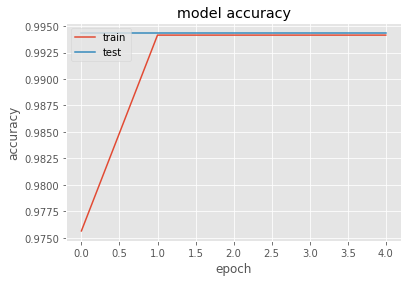

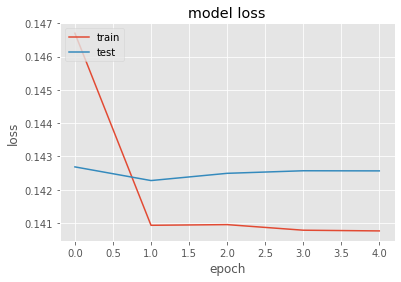

In [23]:
plot_loss(history)

### RNN

In [25]:
inputs = Input(shape=(maxlen,))
x = Embedding(vocab_size, 100, trainable=False)(inputs)
x = RNN(LSTMCell(20))(x)
outputs = Dense(n, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
rnn (RNN)                    (None, 20)                9680      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 14,834,106
Trainable params: 9,806
Non-trainable params: 14,824,300
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 219s 274ms/step - loss: 0.1702 - acc: 0.8390 - val_loss: 0.1424 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 216s 270ms/step - loss: 0.1406 - acc: 0.9941 - val_loss: 0.1424 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 216s 271ms/step - loss: 0.1406 - acc: 0.9941 - val_loss: 0.1424 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 219s 275ms/step - loss: 0.1406 - acc: 0.9941 - val_loss: 0.1424 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 221s 277ms/step - loss: 0.1406 - acc: 0.9941 - val_loss: 0.1424 - val_acc: 0.9943


In [27]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 26s 26ms/step - loss: 0.1418 - acc: 0.9941
Test Score: 0.14176449179649353
Test Accuracy: 0.9941093325614929


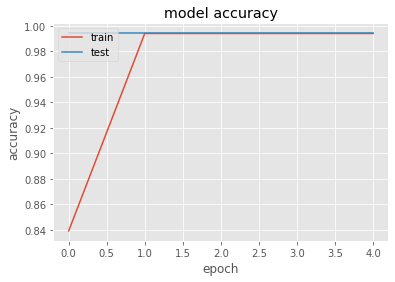

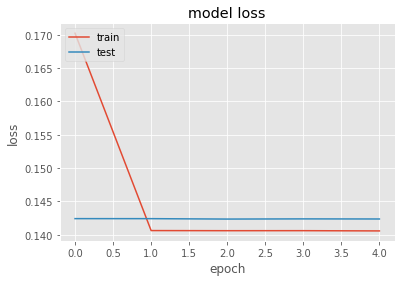

In [28]:
plot_loss(history)

### Convolutional 1D

In [21]:
inputs = Input(shape=(maxlen,))
x = Embedding(vocab_size, 100, trainable=False)(inputs)
x = Conv1D(filters=20, kernel_size=4, strides=2, padding='valid')(x)
x = GRU(20, return_sequences=True)(x)
x = GRU(20)(x)
outputs = Dense(n, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
conv1d (Conv1D)              (None, 99, 20)            8020      
_________________________________________________________________
gru_1 (GRU)                  (None, 99, 20)            2520      
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 14,837,486
Trainable params: 13,186
Non-trainable params: 14,824,300
_____________________________________

In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 38s 48ms/step - loss: 0.1568 - acc: 0.9495 - val_loss: 0.1423 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 37s 47ms/step - loss: 0.1401 - acc: 0.9938 - val_loss: 0.1402 - val_acc: 0.9940
Epoch 3/5
798/798 [==============================] - 37s 47ms/step - loss: 0.1127 - acc: 0.9859 - val_loss: 0.0996 - val_acc: 0.9935
Epoch 4/5
798/798 [==============================] - 37s 46ms/step - loss: 0.0949 - acc: 0.9938 - val_loss: 0.0941 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 37s 46ms/step - loss: 0.0911 - acc: 0.9941 - val_loss: 0.0917 - val_acc: 0.9943


In [23]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 16s 16ms/step - loss: 0.0918 - acc: 0.9941
Test Score: 0.09177779406309128
Test Accuracy: 0.9941093325614929


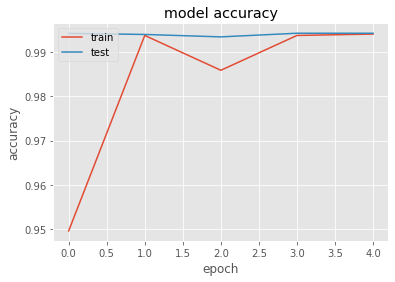

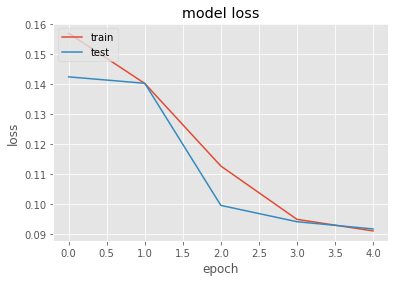

In [24]:
plot_loss(history)